# Experiment 2: Memory Management

Please run each cell, and follow the instructions at the end in the "Analyze Results" section.

In [18]:
from __future__ import annotations

import importlib
import os
import pathlib

import plotly.express as px
import plotly.graph_objects as go
import polars
import theme

from plotly.colors import hex_to_rgb, label_rgb

importlib.reload(theme)

<module 'theme' from '/Users/jgpaul/workspace/tpds24-evaluation/notebooks/theme.py'>

In [13]:
def load_data(directory):
    run_data = polars.concat(
        polars.read_csv(f)
        for f in pathlib.Path(directory).glob('**/results.csv')
    )
    memory_log = polars.concat(
        polars.read_csv(f)
        for f in pathlib.Path(directory).glob('**/results-memory.csv')
    )
    return run_data, memory_log

In [14]:
def extract_memory_logs(run_data, memory_log):
    memory_logs = {}

    data_management_methods = (
        run_data.select(polars.col('data_management')).to_series().to_list()
    )

    for data_management in data_management_methods:
        runs = run_data.filter(
            polars.col('data_management') == data_management,
        )

        run_memory_logs = []
        for i, run in enumerate(runs.iter_rows(named=True)):
            run_start = run['workflow_start_timestamp']
            run_end = run['workflow_end_timestamp']

            run_memory_log = memory_log.filter(
                run_start <= polars.col('unix_timestamp'),
            ).filter(polars.col('unix_timestamp') <= run_end)
            run_memory_log = (
                run_memory_log.select(
                    # Round to 10 ms here
                    (polars.col('unix_timestamp') - run_start)
                    .round(2)
                    .alias('timestamp'),
                    (
                        (
                            polars.col('total_bytes')
                            - polars.col('available_bytes')
                        )
                        / int(1e9)
                    ).alias('used_gb'),
                )
                .group_by('timestamp', maintain_order=True)
                .mean()
                .sort('timestamp')
            )
            run_memory_log = run_memory_log.select(
                polars.col('timestamp'),
                polars.col('used_gb').alias(f'run-{i}-used_gb'),
            )
            run_memory_logs.append(run_memory_log)

        for i in range(1, len(run_memory_logs)):
            run_memory_logs[0] = (
                run_memory_logs[0]
                .join(
                    run_memory_logs[i],
                    on='timestamp',
                    how='outer_coalesce',
                )
                .sort('timestamp')
                .select(polars.all().forward_fill())
            )

        memory_logs[data_management] = run_memory_logs[0].select(
            polars.col('timestamp'),
            polars.concat_list(polars.col('^run-\d+-used_gb$'))
            .list.mean()
            .alias('mean_used_gb'),
            polars.concat_list(polars.col('^run-\d+-used_gb$'))
            .list.std()
            .alias('std_used_gb'),
        )

    return memory_logs

In [19]:
def generate_figure(memory_logs, layout=None):
    fig = go.Figure()

    names = {
        'none': 'No Proxy',
        'default-proxy': 'Default Proxy',
        'manual-proxy': 'Manual Proxy',
        'owned-proxy': 'Ownership',
    }

    max_x = 0
    max_y = 0

    colors = [theme.colors[c] for c in reversed(['purple', 'green', 'blue', 'orange'])]
    for i, data_management in enumerate(names.keys()):
        if data_management not in memory_logs:
            continue
        memory_profile = memory_logs[data_management]
        color = label_rgb(hex_to_rgb(colors[i]))
        fill_color = color.replace(')', ', 0.25)').replace('rgb', 'rgba')
        scatter_line = go.Scatter(
            x=memory_profile['timestamp'],
            y=memory_profile['mean_used_gb'],
            name=names[data_management],
            line=dict(color=colors[i]),
            mode='lines',
        )
        scatter_upper = go.Scatter(
            x=memory_profile['timestamp'],
            y=memory_profile['mean_used_gb'] + memory_profile['std_used_gb'],
            name=f'{data_management}-stdev-upper',
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False,
        )
        scatter_lower = go.Scatter(
            x=memory_profile['timestamp'],
            y=memory_profile['mean_used_gb'] - memory_profile['std_used_gb'],
            name=f'{data_management}-stdev-lower',
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor=fill_color,
            fill='tonexty',
            showlegend=False,
        )

        if data_management == 'default-proxy':
            max_x = max(memory_profile['timestamp'])
        max_y = max(max_y, memory_profile['mean_used_gb'].max())

        fig.add_trace(scatter_line)
        fig.add_trace(scatter_upper)
        fig.add_trace(scatter_lower)

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Memory Management'},
        xaxis_title='Runtime (s)',
        yaxis_title='System Memory (GB)',
        yaxis={'tickformat': '.0f'},
        xaxis_range=[0, 1.25 * max_x],
        # yaxis_range=[0, 1.4 * max_y],
        legend=dict(
            yanchor='top',
            y=0.9,
            xanchor='left',
            x=1.01,
            # title='Proxy Management',
            # traceorder='reversed',
        ),
        template='proxystore',
        **layout,
    )

    return fig

## Analyze Results

To analyze results produced by the `scripts/{system}/2-memory-management.sh` script, replace the `path` variable below with the correct path to your output directory.
This will likely be in `../data/{system}/2-memory-management/`, and this directory will contain multiple subdirectories timestamped for each run to process.

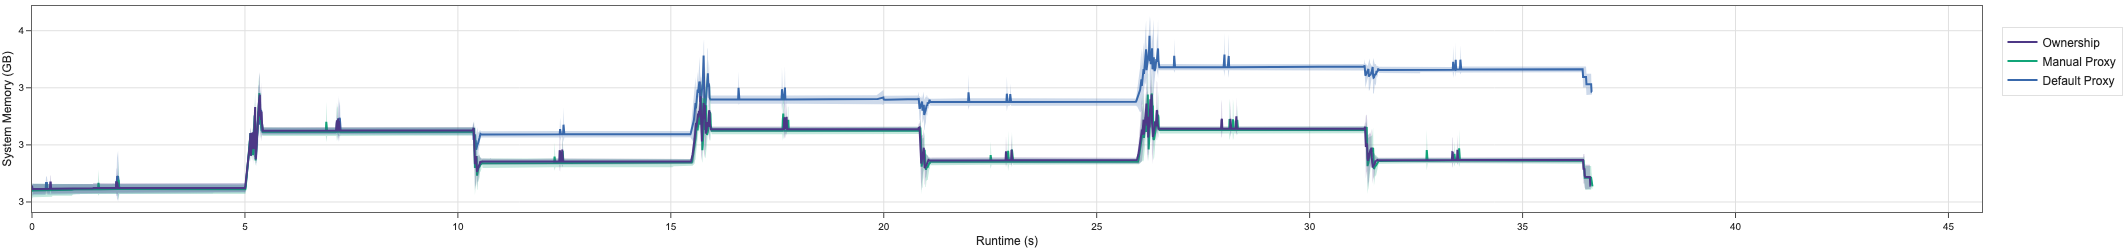

In [20]:
path = '../data/alderaan/2-memory-management'

if not os.path.isdir(path):
    print(f'The directory {path} does not exist.')
else:
    run_data, memory_log = load_data(path)

    memory_logs = extract_memory_logs(run_data, memory_log)

    layout = dict(width=500, height=250)

    fig = generate_figure(memory_logs, layout)
    fig.show()  # renderer='svg')

    figure_dir = pathlib.Path('../figures/alderaan/')
    figure_dir.mkdir(exist_ok=True)
    fig.write_image(figure_dir / '2-memory-management.pdf')

## Polaris Results

The following block processes the exact data used to produce the figures in our SC24 submission.
You do not need to modify this block, unless you would like to further explore the results of our experimental runs.

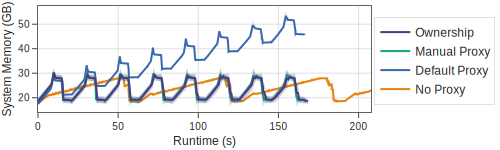

In [21]:
run_data, memory_log = load_data('../data/polaris/2-memory-management')
memory_logs = extract_memory_logs(run_data, memory_log)

layout = dict(width=500, height=150)  # , yaxis_range=[12.6, 15.1])

fig = generate_figure(memory_logs, layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/polaris/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '2-memory-management.pdf')